# LoL Churn Predictor [Part 2 - Data Cleaning and EDA]

**David Skarbrevik - 2018**

In part 1 we acquired League of Legends player gameplay data. Now we want to make sure our data is in good shape and perform some basic analysis to see if we can learn anything interesting about our data before we move on to modeling our churn prediction task.

<a id="toc"></a>

<br>
<hr style="background-color: black; padding: 1px;">
<br>

<h2>Table of Contents</h2>

<br>

<ol>
    <h3><li><a href="#section1">Planning</a></li></h3>
    <br>
    <h3><li><a href="#section2">Data cleaning</a></li></h3>
    <br>
    <h3><li><a href="#section3">Exploratory Data Analysis</a></li></h3>
</ol>

<br>
<hr style="background-color: black; padding: 1px;">
<br>

<a id='section1'></a>

## Step 1) Planning

### What kind of cleaning should I look into?

* check for missing data
* check for duplicate data
* make sure data is organized in an easily readable way

### What kind of basic questions would I like to ask of the data?

* Are the players under level 3 losing their first match more than those that get past level 3?
* Do the players under level 3 have a much lower KDA in their first match than those that get past level 3?
* How long is the average game for players at these low levels?

### Best visualizations to summarize this data?

* histogram of summoner level
* Bar charts of a few different stats, grouped by summoner level

### Assumptions / bias of this dataset [very important disclaimer]

While the Riot API theoretically gives access to ALL players of League of Legends, I made very specific restraints on what players would make it to my dataset when I collected my data. 

There were two main constraints:

**1) time constraint:** the player must have had their first match in 2018 and their most recent match (whether first or not) must not be more recent than 1 month before I collected their data.

**2) level constraint:** the player must not have a summoner level above 5.

The upper time constraint exists so that I can ensure that enough time has passed for a player to have "churned" by my definition (1 month of inactivity). And the lower time constraint exists to ensure that all players come from a similar time in the history of League of Legends. This keeps models more relevant to Riot's current situation while also holding many variables, that would confound analysis, a little more constant.

The level cap exists because of the method used to collect data. There is no easy way to get an even distribution of summoner levels, and since I am interested in new players, it is easiest to only collect data from low level players.

However, this means that any analysis of the data must always keep in mind that **this is a very specific sample of League of Legends players and is likely not representative of the population of all players.**

***

<div align="right">
    <a href="#toc">back to top</a>
</div>
<a id='section2'></a>

## Step 2) Data Cleaning

In [1]:
import pandas as pd
import numpy as np
from collections import Counter

In [2]:
# this dataset has over 100 columns so pandas will truncate our results by default
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

**Import data**

In [17]:
df = pd.read_csv("./data/riot_master_df.csv", encoding="ISO-8859-1")

**Overview of Data**

In [18]:
df.head()

,assists,champLevel,combatPlayerScore,creepsPerMinDeltas_0-10,creepsPerMinDeltas_10-20,creepsPerMinDeltas_20-30,creepsPerMinDeltas_30-end,csDiffPerMinDeltas_0-10,csDiffPerMinDeltas_10-20,csDiffPerMinDeltas_20-30,csDiffPerMinDeltas_30-end,damageDealtToObjectives,damageDealtToTurrets,damageSelfMitigated,damageTakenDiffPerMinDeltas_0-10,damageTakenDiffPerMinDeltas_10-20,damageTakenDiffPerMinDeltas_20-30,damageTakenDiffPerMinDeltas_30-end,damageTakenPerMinDeltas_0-10,damageTakenPerMinDeltas_10-20,damageTakenPerMinDeltas_20-30,damageTakenPerMinDeltas_30-end,deaths,doubleKills,firstBloodAssist,firstBloodKill,firstInhibitorAssist,firstInhibitorKill,firstTowerAssist,firstTowerKill,first_match_duration,first_match_id,first_match_time,goldEarned,goldPerMinDeltas_0-10,goldPerMinDeltas_10-20,goldPerMinDeltas_20-30,goldPerMinDeltas_30-end,goldSpent,id,inhibitorKills,item0,item1,item2,item3,item4,item5,item6,killingSprees,kills,lane,largestCriticalStrike,largestKillingSpree,largestMultiKill,latest_match_time,longestTimeSpentLiving,magicDamageDealt,magicDamageDealtToChampions,magicalDamageTaken,neutralMinionsKilled,neutralMinionsKilledEnemyJungle,neutralMinionsKilledTeamJungle,objectivePlayerScore,participantId,pentaKills,perkPrimaryStyle,perkSubStyle,physicalDamageDealt,physicalDamageDealtToChampions,physicalDamageTaken,playerScore0,playerScore1,playerScore2,playerScore3,playerScore4,playerScore5,playerScore6,playerScore7,playerScore8,playerScore9,quadraKills,role,sightWardsBoughtInGame,summoner_id,summoner_level,summoner_name,timeCCingOthers,totalDamageDealt,totalDamageDealtToChampions,totalDamageTaken,totalHeal,totalMinionsKilled,totalPlayerScore,totalScoreRank,totalTimeCrowdControlDealt,totalUnitsHealed,total_matches,tripleKills,trueDamageDealt,trueDamageDealtToChampions,trueDamageTaken,turretKills,unrealKills,visionScore,visionWardsBoughtInGame,wardsKilled,wardsPlaced,win,xpDiffPerMinDeltas_0-10,xpDiffPerMinDeltas_10-20,xpDiffPerMinDeltas_20-30,xpDiffPerMinDeltas_30-end,xpPerMinDeltas_0-10,xpPerMinDeltas_10-20,xpPerMinDeltas_20-30,xpPerMinDeltas_30-end
0,16.0,12.0,0.0,5.1,0.0,0.0,0.0,4.80,0.0,0.0,0.0,4624.0,4624.0,4268.0,-205.3,0.0,0.0,0.0,388.2,0.0,0.0,0.0,0.0,0.0,False,False,True,False,False,False,0 days 00:14:00.000000000,2695060245,2018-01-16T05:50:54.986000+00:00,8012.0,496.3,0.0,0.0,0.0,2850.0,4.0,0.0,1054.0,3044.0,3067.0,1001.0,0.0,0.0,3340.0,1.0,13.0,MIDDLE,456.0,13.0,1.0,2018-01-17T06:05:14.227000+00:00,0.0,3005.0,2392.0,1005.0,0.0,0.0,0.0,0.0,4.0,0.0,8400.0,8200.0,48136.0,11330.0,7246.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,SOLO,0.0,92201075,5,TrEx18,18.0,51142.0,13723.0,8252.0,1128.0,63.0,0.0,0.0,274.0,1.0,7,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,True,371.20,0.0,0.0,0.0,583.9,0.0,0.0,0.0
1,4.0,11.0,0.0,3.5,0.0,0.0,0.0,1.72,0.0,0.0,0.0,1885.0,1885.0,5206.0,-200.0,0.0,0.0,0.0,478.0,0.0,0.0,0.0,2.0,3.0,False,False,False,False,False,False,0 days 00:16:41.000000000,2736710108,2018-03-10T06:24:33.477000+00:00,9014.0,318.3,0.0,0.0,0.0,8850.0,2.0,0.0,3142.0,3147.0,3111.0,1043.0,1036.0,1055.0,3340.0,2.0,13.0,NONE,0.0,9.0,2.0,2018-03-10T14:58:21.007000+00:00,654.0,968.0,888.0,3374.0,4.0,4.0,0.0,0.0,2.0,0.0,8100.0,8000.0,46817.0,12594.0,7109.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DUO_SUPPORT,0.0,93650017,5,iMain N01,59.0,52490.0,13817.0,11503.0,3662.0,58.0,0.0,0.0,123.0,1.0,6,0.0,4704.0,334.0,1019.0,0.0,0.0,3.0,0.0,0.0,3.0,True,84.66,0.0,0.0,0.0,363.9,0.0,0.0,0.0
2,10.0,13.0,0.0,0.8,3.6,0.0,0.0,NaN,NaN,NaN,NaN,6838.0,5972.0,11147.0,NaN,NaN,NaN,NaN,564.3,862.1,0.0,0.0,2.0,0.0,False,False,True,False,False,False,0 days 00:22:54.000000000,2736716714,2018-03-10T06:56:11.750000+00:00,10869.0,353.0,412.7,0.0,0.0,6800.0,2.0,0.0,2003.0,1055.0,3133.0,3071.0,3076.0,3086.0,3340.0,3.0,10.0,JUNGLE,499.0,5.0,1.0,2018-03-21T08:32:17.048000+00:00,419.0,1229.0,288.0,2291.0,16.0,0.0,13.0,0.0,2.0,0.0,8100.0,8000.0,67383.0,10907.0,14573.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NONE,0.0,92729877,5,luexolu99,36.0,70890.0,11789.0,16942.0,879

In [19]:
df.shape

(1598, 116)

**Is there missing data?**

In [20]:
if df[df.isnull().any(axis=1)].empty:
    print("No missing values!")
else:
    print("Missing data from {} rows".format(df[df.isnull().any(axis=1)].shape[0]))

Missing data from 462 rows


**What columns are missing data?**

In [21]:
df.isnull().sum()

assists                                 1
champLevel                              1
combatPlayerScore                       1
creepsPerMinDeltas_0-10                 5
creepsPerMinDeltas_10-20                5
creepsPerMinDeltas_20-30                5
creepsPerMinDeltas_30-end               5
csDiffPerMinDeltas_0-10               446
csDiffPerMinDeltas_10-20              446
csDiffPerMinDeltas_20-30              446
csDiffPerMinDeltas_30-end             446
damageDealtToObjectives                 1
damageDealtToTurrets                    1
damageSelfMitigated                     1
damageTakenDiffPerMinDeltas_0-10      446
damageTakenDiffPerMinDeltas_10-20     446
damageTakenDiffPerMinDeltas_20-30     446
damageTakenDiffPerMinDeltas_30-end    446
damageTakenPerMinDeltas_0-10            5
damageTakenPerMinDeltas_10-20           5
damageTakenPerMinDeltas_20-30           5
damageTakenPerMinDeltas_30-end          5
deaths                                  1
doubleKills                       

**Dealing with the missing data**

We see that a lot of the columns are only missing 1 data point, this could be from a single player. Let's take a look:

In [22]:
df.loc[df['assists'].isnull()]

,assists,champLevel,combatPlayerScore,creepsPerMinDeltas_0-10,creepsPerMinDeltas_10-20,creepsPerMinDeltas_20-30,creepsPerMinDeltas_30-end,csDiffPerMinDeltas_0-10,csDiffPerMinDeltas_10-20,csDiffPerMinDeltas_20-30,csDiffPerMinDeltas_30-end,damageDealtToObjectives,damageDealtToTurrets,damageSelfMitigated,damageTakenDiffPerMinDeltas_0-10,damageTakenDiffPerMinDeltas_10-20,damageTakenDiffPerMinDeltas_20-30,damageTakenDiffPerMinDeltas_30-end,damageTakenPerMinDeltas_0-10,damageTakenPerMinDeltas_10-20,damageTakenPerMinDeltas_20-30,damageTakenPerMinDeltas_30-end,deaths,doubleKills,firstBloodAssist,firstBloodKill,firstInhibitorAssist,firstInhibitorKill,firstTowerAssist,firstTowerKill,first_match_duration,first_match_id,first_match_time,goldEarned,goldPerMinDeltas_0-10,goldPerMinDeltas_10-20,goldPerMinDeltas_20-30,goldPerMinDeltas_30-end,goldSpent,id,inhibitorKills,item0,item1,item2,item3,item4,item5,item6,killingSprees,kills,lane,largestCriticalStrike,largestKillingSpree,largestMultiKill,latest_match_time,longestTimeSpentLiving,magicDamageDealt,magicDamageDealtToChampions,magicalDamageTaken,neutralMinionsKilled,neutralMinionsKilledEnemyJungle,neutralMinionsKilledTeamJungle,objectivePlayerScore,participantId,pentaKills,perkPrimaryStyle,perkSubStyle,physicalDamageDealt,physicalDamageDealtToChampions,physicalDamageTaken,playerScore0,playerScore1,playerScore2,playerScore3,playerScore4,playerScore5,playerScore6,playerScore7,playerScore8,playerScore9,quadraKills,role,sightWardsBoughtInGame,summoner_id,summoner_level,summoner_name,timeCCingOthers,totalDamageDealt,totalDamageDealtToChampions,totalDamageTaken,totalHeal,totalMinionsKilled,totalPlayerScore,totalScoreRank,totalTimeCrowdControlDealt,totalUnitsHealed,total_matches,tripleKills,trueDamageDealt,trueDamageDealtToChampions,trueDamageTaken,turretKills,unrealKills,visionScore,visionWardsBoughtInGame,wardsKilled,wardsPlaced,win,xpDiffPerMinDeltas_0-10,xpDiffPerMinDeltas_10-20,xpDiffPerMinDeltas_20-30,xpDiffPerMinDeltas_30-end,xpPerMinDeltas_0-10,xpPerMinDeltas_10-20,xpPerMinDeltas_20-30,xpPerMinDeltas_30-end
982,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0 days 00:15:28,2717262656,2018-02-12T21:53:43.622000+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TOP,NaN,NaN,NaN,2018-02-15T18:09:10.473000+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DUO,NaN,92790619,3,ChiefShonah,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Perhaps this player left his first game right as it started? Though if that is the reason, it's amazing there aren't at least a few more cases in our dataset like this. 

Let's see what the NaN column counts look like after we remove this player.

In [23]:
df = df.drop(df.index[982]) # drop one specific player

In [24]:
df.isnull().sum()

assists                                 0
champLevel                              0
combatPlayerScore                       0
creepsPerMinDeltas_0-10                 4
creepsPerMinDeltas_10-20                4
creepsPerMinDeltas_20-30                4
creepsPerMinDeltas_30-end               4
csDiffPerMinDeltas_0-10               445
csDiffPerMinDeltas_10-20              445
csDiffPerMinDeltas_20-30              445
csDiffPerMinDeltas_30-end             445
damageDealtToObjectives                 0
damageDealtToTurrets                    0
damageSelfMitigated                     0
damageTakenDiffPerMinDeltas_0-10      445
damageTakenDiffPerMinDeltas_10-20     445
damageTakenDiffPerMinDeltas_20-30     445
damageTakenDiffPerMinDeltas_30-end    445
damageTakenPerMinDeltas_0-10            4
damageTakenPerMinDeltas_10-20           4
damageTakenPerMinDeltas_20-30           4
damageTakenPerMinDeltas_30-end          4
deaths                                  0
doubleKills                       

OK, most of the columns don't have NaNs now, but a lot have exactly 4 or 445 missing values. These are all features with a time component, so it is likely that these games just didn't go long enough to produce values. However, because the 0-10min category also has 445 missing values it's possible that these are all players that dropped their first game shortly after joining the match. It should be appropriate to set those columns to 0.

But let's see what the data for these players looks like before we do that:

In [25]:
df.loc[df['xpDiffPerMinDeltas_0-10'].isnull()].head(n=10) # just choosing one of the time features, doesn't matter

,assists,champLevel,combatPlayerScore,creepsPerMinDeltas_0-10,creepsPerMinDeltas_10-20,creepsPerMinDeltas_20-30,creepsPerMinDeltas_30-end,csDiffPerMinDeltas_0-10,csDiffPerMinDeltas_10-20,csDiffPerMinDeltas_20-30,csDiffPerMinDeltas_30-end,damageDealtToObjectives,damageDealtToTurrets,damageSelfMitigated,damageTakenDiffPerMinDeltas_0-10,damageTakenDiffPerMinDeltas_10-20,damageTakenDiffPerMinDeltas_20-30,damageTakenDiffPerMinDeltas_30-end,damageTakenPerMinDeltas_0-10,damageTakenPerMinDeltas_10-20,damageTakenPerMinDeltas_20-30,damageTakenPerMinDeltas_30-end,deaths,doubleKills,firstBloodAssist,firstBloodKill,firstInhibitorAssist,firstInhibitorKill,firstTowerAssist,firstTowerKill,first_match_duration,first_match_id,first_match_time,goldEarned,goldPerMinDeltas_0-10,goldPerMinDeltas_10-20,goldPerMinDeltas_20-30,goldPerMinDeltas_30-end,goldSpent,id,inhibitorKills,item0,item1,item2,item3,item4,item5,item6,killingSprees,kills,lane,largestCriticalStrike,largestKillingSpree,largestMultiKill,latest_match_time,longestTimeSpentLiving,magicDamageDealt,magicDamageDealtToChampions,magicalDamageTaken,neutralMinionsKilled,neutralMinionsKilledEnemyJungle,neutralMinionsKilledTeamJungle,objectivePlayerScore,participantId,pentaKills,perkPrimaryStyle,perkSubStyle,physicalDamageDealt,physicalDamageDealtToChampions,physicalDamageTaken,playerScore0,playerScore1,playerScore2,playerScore3,playerScore4,playerScore5,playerScore6,playerScore7,playerScore8,playerScore9,quadraKills,role,sightWardsBoughtInGame,summoner_id,summoner_level,summoner_name,timeCCingOthers,totalDamageDealt,totalDamageDealtToChampions,totalDamageTaken,totalHeal,totalMinionsKilled,totalPlayerScore,totalScoreRank,totalTimeCrowdControlDealt,totalUnitsHealed,total_matches,tripleKills,trueDamageDealt,trueDamageDealtToChampions,trueDamageTaken,turretKills,unrealKills,visionScore,visionWardsBoughtInGame,wardsKilled,wardsPlaced,win,xpDiffPerMinDeltas_0-10,xpDiffPerMinDeltas_10-20,xpDiffPerMinDeltas_20-30,xpDiffPerMinDeltas_30-end,xpPerMinDeltas_0-10,xpPerMinDeltas_10-20,xpPerMinDeltas_20-30,xpPerMinDeltas_30-end
2,10.0,13.0,0.0,0.8,3.6,0.0,0.0,NaN,NaN,NaN,NaN,6838.0,5972.0,11147.0,NaN,NaN,NaN,NaN,564.3,862.1,0.0,0.0,2.0,0.0,False,False,True,False,False,False,0 days 00:22:54.000000000,2736716714,2018-03-10T06:56:11.750000+00:00,10869.0,353.0,412.7,0.0,0.0,6800.0,2.0,0.0,2003.0,1055.0,3133.0,3071.0,3076.0,3086.0,3340.0,3.0,10.0,JUNGLE,499.0,5.0,1.0,2018-03-21T08:32:17.048000+00:00,419.0,1229.0,288.0,2291.0,16.0,0.0,13.0,0.0,2.0,0.0,8100.0,8000.0,67383.0,10907.0,14573.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NONE,0.0,92729877,5,luexolu99,36.0,70890.0,11789.0,16942.0,8791.0,50.0,0.0,0.0,145.0,1.0,4,0.0,2277.0,593.0,77.0,2.0,0.0,0.0,0.0,0.0,0.0,True,NaN,NaN,NaN,NaN,331.8,464.2,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,False,False,0 days 00:28:54.000000000,2736217337,2018-03-09T13:05:59.377000+00:00,5089.0,100.0,164.5,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TOP,0.0,0.0,0.0,2018-03-09T13:05:59.377000+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,8400.0,8200.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DUO_SUPPORT,0.0,93839689,1,Md95359,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
5,7.0,15.0,0.0,3.5,5.4,0.0,0.0,NaN,NaN,NaN,NaN,2130.0,2130.0,16903.0,NaN,NaN,NaN,NaN,321.5,740.3,0.0,0.0,5.0,3.0,False,False,True,False,False,False,0 days 00:26:05.000000000,2741305286,2018-03-16T20:15:31.237000+00:00,12784.0,386.4,518.8,0.0,0.0,12200.0,5.0,0.0,3072.0,3046.0,1029.0,3006.0,3031.0,0.0,3340.0,3.0,14.0,MIDDLE,665.0,7.0,2.0,2018-03-18T07:38:08.817000+00:00,780.0,6271.0,704.0,6075.0,12.0,8.0,4.0,0.0,5.0,0.0,8000.0,8200.0,106662.0,30303.0,11636.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DUO,0.0,93782084,5,Häsagi,40.0,112934.0,31008.0,18013.0,1967.0,109.0,0.0,0.0,110.0,1.0,6,0.0,0.0,0.0,301.0,1.0,0.0,0.0,0.0,0.0,0.0,True,Na

It appears that the these players actually did play their first match through, there was just an issue collecting the "timeline" data. 

**Possible solutions:**

**1) set all timeline NaNs to 0**

2) drop all timeline data from dataset

3) take summoner ids that have NaNs and re-mine their data to see if I can get it

**I'm going to try option 1**, but ultimately I'll want to take the time to do option 3 to reduce noise in my data and models.

In [26]:
time_columns = [i for i,x in enumerate(df.isnull().sum().tolist()) if x == 445 or x == 4] # columns with missing time data
time_cols = list(df.iloc[:, time_columns])
values = {col:0 for col in time_cols}
df = df.fillna(value = values)

In [27]:
df.isnull().sum()

assists                                0
champLevel                             0
combatPlayerScore                      0
creepsPerMinDeltas_0-10                0
creepsPerMinDeltas_10-20               0
creepsPerMinDeltas_20-30               0
creepsPerMinDeltas_30-end              0
csDiffPerMinDeltas_0-10                0
csDiffPerMinDeltas_10-20               0
csDiffPerMinDeltas_20-30               0
csDiffPerMinDeltas_30-end              0
damageDealtToObjectives                0
damageDealtToTurrets                   0
damageSelfMitigated                    0
damageTakenDiffPerMinDeltas_0-10       0
damageTakenDiffPerMinDeltas_10-20      0
damageTakenDiffPerMinDeltas_20-30      0
damageTakenDiffPerMinDeltas_30-end     0
damageTakenPerMinDeltas_0-10           0
damageTakenPerMinDeltas_10-20          0
damageTakenPerMinDeltas_20-30          0
damageTakenPerMinDeltas_30-end         0
deaths                                 0
doubleKills                            0
firstBloodAssist

OK now there are a few more features with NaNs. 

Let's look at "perkSubStyle":

In [28]:
df.loc[df['perkSubStyle'].isnull()].head(n=10)

,assists,champLevel,combatPlayerScore,creepsPerMinDeltas_0-10,creepsPerMinDeltas_10-20,creepsPerMinDeltas_20-30,creepsPerMinDeltas_30-end,csDiffPerMinDeltas_0-10,csDiffPerMinDeltas_10-20,csDiffPerMinDeltas_20-30,csDiffPerMinDeltas_30-end,damageDealtToObjectives,damageDealtToTurrets,damageSelfMitigated,damageTakenDiffPerMinDeltas_0-10,damageTakenDiffPerMinDeltas_10-20,damageTakenDiffPerMinDeltas_20-30,damageTakenDiffPerMinDeltas_30-end,damageTakenPerMinDeltas_0-10,damageTakenPerMinDeltas_10-20,damageTakenPerMinDeltas_20-30,damageTakenPerMinDeltas_30-end,deaths,doubleKills,firstBloodAssist,firstBloodKill,firstInhibitorAssist,firstInhibitorKill,firstTowerAssist,firstTowerKill,first_match_duration,first_match_id,first_match_time,goldEarned,goldPerMinDeltas_0-10,goldPerMinDeltas_10-20,goldPerMinDeltas_20-30,goldPerMinDeltas_30-end,goldSpent,id,inhibitorKills,item0,item1,item2,item3,item4,item5,item6,killingSprees,kills,lane,largestCriticalStrike,largestKillingSpree,largestMultiKill,latest_match_time,longestTimeSpentLiving,magicDamageDealt,magicDamageDealtToChampions,magicalDamageTaken,neutralMinionsKilled,neutralMinionsKilledEnemyJungle,neutralMinionsKilledTeamJungle,objectivePlayerScore,participantId,pentaKills,perkPrimaryStyle,perkSubStyle,physicalDamageDealt,physicalDamageDealtToChampions,physicalDamageTaken,playerScore0,playerScore1,playerScore2,playerScore3,playerScore4,playerScore5,playerScore6,playerScore7,playerScore8,playerScore9,quadraKills,role,sightWardsBoughtInGame,summoner_id,summoner_level,summoner_name,timeCCingOthers,totalDamageDealt,totalDamageDealtToChampions,totalDamageTaken,totalHeal,totalMinionsKilled,totalPlayerScore,totalScoreRank,totalTimeCrowdControlDealt,totalUnitsHealed,total_matches,tripleKills,trueDamageDealt,trueDamageDealtToChampions,trueDamageTaken,turretKills,unrealKills,visionScore,visionWardsBoughtInGame,wardsKilled,wardsPlaced,win,xpDiffPerMinDeltas_0-10,xpDiffPerMinDeltas_10-20,xpDiffPerMinDeltas_20-30,xpDiffPerMinDeltas_30-end,xpPerMinDeltas_0-10,xpPerMinDeltas_10-20,xpPerMinDeltas_20-30,xpPerMinDeltas_30-end
226,3.0,9.0,0.0,0.3,0.0,0.0,0.0,1.44,0.00,0.0,0.0,3619.0,3619.0,5428.0,-36.42,0.00,0.0,0.0,415.5,0.0,0.0,0.0,6.0,0.0,False,False,False,False,False,False,0 days 00:19:04.000000000,2736312050,2018-03-09T20:23:32.929000+00:00,6213.0,171.3,0.0,0.0,0.0,1250.0,5.0,0.0,1056.0,1026.0,0.0,0.0,0.0,0.0,3341.0,0.0,1.0,NONE,0.0,0.0,1.0,2018-03-17T17:44:56.142000+00:00,251.0,9006.0,1256.0,2489.0,0.0,0.0,0.0,0.0,5.0,0.0,8200.0,NaN,7273.0,854.0,5197.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DUO_SUPPORT,0.0,93689587,5,spicyemperor908,0.0,23342.0,2782.0,7687.0,1359.0,20.0,0.0,0.0,15.0,3.0,9,0.0,7062.0,672.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,True,83.02,0.0,0.0,0.0,153.9,0.0,0.0,0.0
269,4.0,14.0,0.0,3.4,2.2,0.0,0.0,0.00,0.00,0.0,0.0,3245.0,3245.0,11722.0,0.00,0.00,0.0,0.0,139.1,706.7,0.0,0.0,0.0,0.0,False,False,False,False,False,True,0 days 00:29:06.000000000,2736833894,2018-03-10T14:20:37.391000+00:00,12213.0,336.0,364.7,0.0,0.0,5300.0,2.0,0.0,1054.0,1054.0,3044.0,3111.0,3067.0,3044.0,3340.0,1.0,16.0,MIDDLE,0.0,16.0,1.0,2018-03-11T03:25:16.314000+00:00,0.0,7765.0,4105.0,5165.0,2.0,2.0,0.0,0.0,2.0,0.0,8400.0,NaN,55694.0,14893.0,9645.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DUO_CARRY,0.0,93879843,5,GregJuan,20.0,67435.0,18999.0,14810.0,1486.0,74.0,0.0,0.0,157.0,1.0,5,0.0,3975.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,True,0.00,0.0,0.0,0.0,516.9,320.8,0.0,0.0
272,15.0,7.0,0.0,0.4,0.0,0.0,0.0,0.94,0.00,0.0,0.0,862.0,862.0,2395.0,-385.64,0.00,0.0,0.0,338.9,0.0,0.0,0.0,4.0,0.0,False,False,True,False,True,False,0 days 00:12:28.000000000,2743505380,2018-03-19T05:31:31.571000+00:00,4463.0,299.7,0.0,0.0,0.0,3150.0,2.0,0.0,3111.0,3044.0,3067.0,0.0,0.0,0.0,3340.0,1.0,3.0,NONE,0.0,2.0,1.0,2018-03-19T06:07:50.345000+00:00,242.0,611.0,443.0,249.0,0.0,0.0,0.0,0.0,2.0,0.0,8400.0,NaN,9466.0,2954.0,4761.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DUO_SUPPORT,0.0,27808934,4,DeathOni,5.0,12818.0,3397.0,5011.0,65.0,7.0,0.0,0.0,65.0

What are some normal values for this feature?

In [29]:
Counter(df['perkSubStyle'])

Counter({8000.0: 234,
         8100.0: 504,
         8200.0: 843,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1})

I'm not sure what this feature describes, but because not all players have just one value, this may be a useful feature. Because only a small percent of players are missing this value, I am simply going to remove those players from the dataset.

In [30]:
perksub_nan = list(df.loc[df['perkSubStyle'].isnull()].index.values)
df = df.drop(perksub_nan)

Now let's look at the last 4 features with NaN values:

In [31]:
features_with_nan = ["firstInhibitorAssist", "firstInhibitorKill", "firstTowerAssist", "firstTowerKill"]

for feature in features_with_nan:
    print("Feature name: {}".format(feature))
    print(Counter(df[feature]))
    print("\n")

Feature name: firstInhibitorAssist
Counter({False: 1274, True: 302, nan: 5})


Feature name: firstInhibitorKill
Counter({False: 1388, True: 188, nan: 5})


Feature name: firstTowerAssist
Counter({False: 1389, True: 191, nan: 1})


Feature name: firstTowerKill
Counter({False: 1379, True: 201, nan: 1})




As with the 'perkSubStyle' feature there are only a few players with NaN values in the features above. I don't want to randomly assign True or False to these players so I will simply drop them.

In [32]:
nan_index = sum([list(df.loc[df[feature].isnull()].index.values) for feature in features_with_nan], [])
df = df.drop(nan_index)

Let's make sure we don't have any more NaN values:

In [33]:
if df[df.isnull().any(axis=1)].empty:
    print("No missing values!")
else:
    print("Missing data from {} rows".format(df[df.isnull().any(axis=1)].shape[0]))

No missing values!


**Dealing with duplicate rows**

In [34]:
print("Number of duplicate rows in dataset: {}".format(Counter(df.duplicated())[True]))

Number of duplicate rows in dataset: 81


In [35]:
old_rows = df.shape[0]

df = df.drop_duplicates()

new_rows = df.shape[0]

diff = old_rows - new_rows

print("Number of rows removed: {}".format(diff))

Number of rows removed: 81


Good, the number of rows we removed equals the number of duplicate rows so that's a good sign! Ideally there would have been 0 duplicate rows, because I have a check in my data collection functions to try and avoid this. But for now we'll just remove our duplicates.

Now let's rearrange some of the features that tell us about a player but won't be useful in training our model. This will make this a more interesting "at first glance" dataset.

In [36]:
columns = list(df)
front_features = ['summoner_id', 'summoner_name', 'summoner_level', 'total_matches',
                  'first_match_time', 'first_match_duration', 'first_match_id']

In [37]:
len(columns)

116

In [38]:
cols_reordered = [item for item in columns if item not in front_features]
cols_reordered = front_features + cols_reordered

In [39]:
df = df[cols_reordered]

In [40]:
df.head()

,summoner_id,summoner_name,summoner_level,total_matches,first_match_time,first_match_duration,first_match_id,assists,champLevel,combatPlayerScore,creepsPerMinDeltas_0-10,creepsPerMinDeltas_10-20,creepsPerMinDeltas_20-30,creepsPerMinDeltas_30-end,csDiffPerMinDeltas_0-10,csDiffPerMinDeltas_10-20,csDiffPerMinDeltas_20-30,csDiffPerMinDeltas_30-end,damageDealtToObjectives,damageDealtToTurrets,damageSelfMitigated,damageTakenDiffPerMinDeltas_0-10,damageTakenDiffPerMinDeltas_10-20,damageTakenDiffPerMinDeltas_20-30,damageTakenDiffPerMinDeltas_30-end,damageTakenPerMinDeltas_0-10,damageTakenPerMinDeltas_10-20,damageTakenPerMinDeltas_20-30,damageTakenPerMinDeltas_30-end,deaths,doubleKills,firstBloodAssist,firstBloodKill,firstInhibitorAssist,firstInhibitorKill,firstTowerAssist,firstTowerKill,goldEarned,goldPerMinDeltas_0-10,goldPerMinDeltas_10-20,goldPerMinDeltas_20-30,goldPerMinDeltas_30-end,goldSpent,id,inhibitorKills,item0,item1,item2,item3,item4,item5,item6,killingSprees,kills,lane,largestCriticalStrike,largestKillingSpree,largestMultiKill,latest_match_time,longestTimeSpentLiving,magicDamageDealt,magicDamageDealtToChampions,magicalDamageTaken,neutralMinionsKilled,neutralMinionsKilledEnemyJungle,neutralMinionsKilledTeamJungle,objectivePlayerScore,participantId,pentaKills,perkPrimaryStyle,perkSubStyle,physicalDamageDealt,physicalDamageDealtToChampions,physicalDamageTaken,playerScore0,playerScore1,playerScore2,playerScore3,playerScore4,playerScore5,playerScore6,playerScore7,playerScore8,playerScore9,quadraKills,role,sightWardsBoughtInGame,timeCCingOthers,totalDamageDealt,totalDamageDealtToChampions,totalDamageTaken,totalHeal,totalMinionsKilled,totalPlayerScore,totalScoreRank,totalTimeCrowdControlDealt,totalUnitsHealed,tripleKills,trueDamageDealt,trueDamageDealtToChampions,trueDamageTaken,turretKills,unrealKills,visionScore,visionWardsBoughtInGame,wardsKilled,wardsPlaced,win,xpDiffPerMinDeltas_0-10,xpDiffPerMinDeltas_10-20,xpDiffPerMinDeltas_20-30,xpDiffPerMinDeltas_30-end,xpPerMinDeltas_0-10,xpPerMinDeltas_10-20,xpPerMinDeltas_20-30,xpPerMinDeltas_30-end
0,92201075,TrEx18,5,7,2018-01-16T05:50:54.986000+00:00,0 days 00:14:00.000000000,2695060245,16.0,12.0,0.0,5.1,0.0,0.0,0.0,4.80,0.0,0.0,0.0,4624.0,4624.0,4268.0,-205.3,0.0,0.0,0.0,388.2,0.0,0.0,0.0,0.0,0.0,False,False,True,False,False,False,8012.0,496.3,0.0,0.0,0.0,2850.0,4.0,0.0,1054.0,3044.0,3067.0,1001.0,0.0,0.0,3340.0,1.0,13.0,MIDDLE,456.0,13.0,1.0,2018-01-17T06:05:14.227000+00:00,0.0,3005.0,2392.0,1005.0,0.0,0.0,0.0,0.0,4.0,0.0,8400.0,8200.0,48136.0,11330.0,7246.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,SOLO,0.0,18.0,51142.0,13723.0,8252.0,1128.0,63.0,0.0,0.0,274.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,True,371.20,0.0,0.0,0.0,583.9,0.0,0.0,0.0
1,93650017,iMain N01,5,6,2018-03-10T06:24:33.477000+00:00,0 days 00:16:41.000000000,2736710108,4.0,11.0,0.0,3.5,0.0,0.0,0.0,1.72,0.0,0.0,0.0,1885.0,1885.0,5206.0,-200.0,0.0,0.0,0.0,478.0,0.0,0.0,0.0,2.0,3.0,False,False,False,False,False,False,9014.0,318.3,0.0,0.0,0.0,8850.0,2.0,0.0,3142.0,3147.0,3111.0,1043.0,1036.0,1055.0,3340.0,2.0,13.0,NONE,0.0,9.0,2.0,2018-03-10T14:58:21.007000+00:00,654.0,968.0,888.0,3374.0,4.0,4.0,0.0,0.0,2.0,0.0,8100.0,8000.0,46817.0,12594.0,7109.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DUO_SUPPORT,0.0,59.0,52490.0,13817.0,11503.0,3662.0,58.0,0.0,0.0,123.0,1.0,0.0,4704.0,334.0,1019.0,0.0,0.0,3.0,0.0,0.0,3.0,True,84.66,0.0,0.0,0.0,363.9,0.0,0.0,0.0
2,92729877,luexolu99,5,4,2018-03-10T06:56:11.750000+00:00,0 days 00:22:54.000000000,2736716714,10.0,13.0,0.0,0.8,3.6,0.0,0.0,0.00,0.0,0.0,0.0,6838.0,5972.0,11147.0,0.0,0.0,0.0,0.0,564.3,862.1,0.0,0.0,2.0,0.0,False,False,True,False,False,False,10869.0,353.0,412.7,0.0,0.0,6800.0,2.0,0.0,2003.0,1055.0,3133.0,3071.0,3076.0,3086.0,3340.0,3.0,10.0,JUNGLE,499.0,5.0,1.0,2018-03-21T08:32:17.048000+00:00,419.0,1229.0,288.0,2291.0,16.0,0.0,13.0,0.0,2.0,0.0,8100.0,8000.0,67383.0,10907.0,14573.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NONE,0.0,36.0,70890.0,11789.0,16942.0,

Lastly, let's save this dataset as a "cleaned_riot_data.csv" file for future use.

In [41]:
df.to_csv("./data/cleaned_riot_data.csv", index=False)

***

<div align="right">
    <a href="#toc">back to top</a>
</div>
<a id='section3'></a>

## Step 3) Exploratory Data Analysis

In [3]:
from scipy import stats, integrate
import matplotlib.pyplot as plt
import seaborn as sns

#%matplotlib inline

In [4]:
df = pd.read_csv("./data/cleaned_riot_data.csv", encoding="ISO-8859-1")

In [5]:
summoner_levels = df.summoner_level
np.mean(summoner_levels)

3.471571906354515

Average summoner level = 3.471571906354515


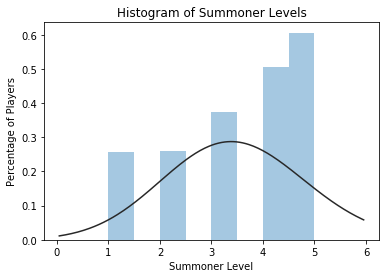

In [12]:
hist = sns.distplot(summoner_levels, kde=False, fit=stats.gamma)
hist.set(title="Histogram of Summoner Levels", xlabel="Summoner Level", ylabel="Percentage of Players")
print("Average summoner level = {}".format(np.mean(df.summoner_level)))

In [13]:
# save high-res for website
hist = hist.get_figure()
hist.savefig("./docs/summoner_level_high_res.png", dpi=1000)

***

<div align="right">
    <a href="#toc">back to top</a>
</div>

## End of Part 2

### In the <a href="https://nbviewer.jupyter.org/github/dskarbrevik/League-of-Legends-Churn-Prediction/blob/master/LoL%20Churn%20Predictor%20%5BPart%203%20-%20Data%20Modeling%5D.ipynb">next notebook</a>, we'll get our data ready for modeling and test out a few models to finally see if we can make our "churn" predictions as we set out to do from the start!